# Integrantes
* ### David Herrera
* ### Estid Lozano
* ### Nicolás González

In [2]:
# Imports
from smlutil import *
from numbers import Number
from mpl_toolkits.mplot3d import axes3d
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
import itertools

# Exercise 1

Suppose that we model, for any instance x, the log-odds ratio between
a class i and the distinguished class K as the dot product of a regression vector i and x, i.e.

$ \log{\frac{P(Y=y_i|X=x)}{P(Y=y_k|X=x)}}=\beta^T_iX $

**a)** Show that this is equivalent to saying that

$ P(Y=y_i|X=x)=\frac{\epsilon^{\beta^T_iX}}{1+\sum^{K-1}_{i=1}\epsilon^{\beta^T_iX}}; for \; i=1,...,K-1 $

$ P(Y=y_k|X=x)=\frac{1}{1+\sum^{K-1}_{i=1}\epsilon^{\beta^T_iX}} $

To determine $ P(Y=y_i|X=x) $ we have:

$ \log{P(Y=y_i|X=x)}=\log{P(Y=y_k|X=x)}+\beta^T_iX $

$ P(Y=y_i|X=x)=P(Y=y_k|X=x)\cdot\epsilon^{\beta^T_iX} $

$ P(Y=y_i|X=x)=\frac{\epsilon^{\beta^T_iX}}{1+\sum^{K-1}_{i=1}\epsilon^{\beta^T_iX}}; for \; i=1,...,K-1 $

To determine $ P(Y=y_k|X=x) $ we have:

$ \log{P(Y=y_k|X=x)}=\log{P(Y=y_i|X=x)}-\beta^T_iX $

$ P(Y=y_k|X=x)=\frac{P(Y=y_i|X=x)}{\beta^T_iX} $

$ P(Y=y_k|X=x)=\frac{1}{1+\sum^{K-1}_{i=1}\epsilon^{\beta^T_iX}} $

**b)** Show that we can also define a vector for class K be setting K = 0 and that this is the
only meaningful value so that Eq. (1) holds also for i = K.

**c)** Show that because of this choice for K, wen can merge Eq. (2) and (3) to

We have: $ \beta^T_K = 0 $

Then: $ \beta^T_KX = 0 $

Then: $ \epsilon^{\beta^T_KX} = 1 $


Then: $ \sum^K_{i=1}\epsilon^{\beta^T_iX} = 1+\sum^{K-1}_{i=1}\epsilon^{\beta^T_iX}$

# Exercise 2


We will now explicitly expand our learner models to deliver probabilistic predictions. Besides the train(X,y) function, they should now implement a function
getProbabilities(X), which should return a n × K numpy array, where an n is the number
of instances in X and K is the number of labels in the considered problem. In this output
array, the cell (i,j) is the probability the model assigned to instance i to belong to class j.

Write a learner Logistic that builds models for multi-class classification problems according
to the algorithm seen in the lecture. Use parameters step_size, eps (for the cancellation
criterion ε, and max_iter for the maximum number of steps.

In [3]:
%matplotlib inline
# %matplotlib widget
"use strict"
class Logistic:
    def __init__(self, _step_size=0.01, _eps=0.01, _max_iter=1000):
        self._step_size = _step_size
        self._eps = _eps
        self._max_iter = _max_iter
    def getName(self):
        return "logistic"
    def train(self, _X, _Y):
        _Y = _Y.astype('object')
        d = len(_X[0])
        n = len(_X)
        self.classes = np.unique(_Y)
        dClasses = len(self.classes)
        _X = np.insert(_X, 0, [1 for i in range(n)], axis=1)
        for i in range(n):
            index = np.where(self.classes == _Y[i])[0][0]
            _Y[i] = np.zeros(dClasses)
            _Y[i][index] = 1
            _Y[i] = _Y[i]
        t = 0
        w = {}
        for j in range(dClasses):
            if j not in w:
                w[j] = []
            w[j].append(np.array([0 for i in range(d+1)]))
        temp = np.arange(n)
        np.random.shuffle(temp)
        _X = _X[temp]
        _Y = _Y[temp]
        pi = {}
        gradient = {}
        while True:
            wCopy = {}
            for j in range(dClasses-1):
                wCopy[j] = w[j][-1]
            for x, y in zip(_X, _Y):
                for j in range(dClasses-1):
                    pi[j] = np.exp(np.dot(wCopy[j], x))/sum([np.exp(np.dot(w[a][-1], x)) for a in range(dClasses)])
                    gradient[j] = (y[j]-pi[j])*x
                    wCopy[j] = wCopy[j]+self._step_size*gradient[j]
            for j in range(dClasses-1):
                w[j].append(wCopy[j])
            t += 1
            if sum([np.linalg.norm(w[j][t]-w[j][t-1]) for j in range(dClasses-1)]) <= self._eps or t > self._max_iter:
                break
        for j in range(dClasses):
            w[j] = w[j][-1]
        self.w = w

    def predict(self, _X):
        res = []
        for x in _X:
            temp = {}
            x = np.insert(x, 0, 1, axis=0)
            for c in self.w:
                temp[c] = math.exp(np.dot(
                    self.w[c], x))/sum([math.exp(np.dot(self.w[a], x)) for a in range(len(self.w.keys()))])
            res.append(self.classes[max(temp, key=temp.get)])
        return res

    def predictAttr(self, _X, attr):
        res = []
        for x in _X:
            x = np.insert(x, 0, 1, axis=0)
            res.append(math.exp(np.dot(self.w[attr], x))/sum([math.exp(np.dot(self.w[a], x)) for a in range(len(self.w.keys()))]))
        return res

    def getProbabilites(self, _X):
        matrix = np.zeros((len(_X),len(self.w.keys())))
        for i in range(len(_X)):
            for j in self.w.keys():
                matrix[i][j]=self.predictAttr([_X[i]],j)[0]
        return matrix


# Exercise 3


**3.1.** Write a function plotModel(h, X, y, xlabel="X1", ylabel="X2") that receives a
probabilistic learner h and the training data (n × 2 numpy array X and n × 1 label
vectory y). The function should train h and then create a series of K (one for each class)
surface or mesh grid plots. In plot i, the surface should show the probabilities assigned
by the model to class i. Also scatter the training points with different colors and shapes
into the plot at height 0 for classes 6= i and height 1 for instances of class i.
Use the minimum and maximum values per attribute to define the scope of the surface.
Use the optional arguments xlabel and ylabel to assign labels to the x-axis and y-axis,
respectively

In [ ]:
def plotModel(_h,_X,_Y,xLabel="X1",yLabel="X2"):
    classes=np.unique(_Y)
    dClassses= len(classes)
    yCopy=_Y.copy()
    _h.train(_X,_Y)
    fig = plt.figure(figsize=(32, 8))
    for ci in range(dClassses):
        Yones = np.where(yCopy == classes[ci], 1, yCopy)
        Yones = np.where(Yones != 1, 0, Yones)
        ax = fig.add_subplot(1,dClassses,ci+1, projection='3d')
        xs=_X[:, 0]
        ys=_X[:, 1]
        ax.scatter(xs=xs, ys=ys, zs=list(Yones), c=list(Yones))
        x = np.linspace(min(xs), max(xs), 30)
        y = np.linspace(min(ys), max(ys), 30)
        xt = []
        for i in range(len(x)):
            xt.append(np.array([x[i], y[i]]))
        Xgrid, Ygrid = np.meshgrid(x, y)
        Zgrid = np.array(_h.predictAttr(xt, ci))/(Xgrid*0+1)
        ax.plot_surface(Xgrid, Ygrid, Zgrid, alpha=0.54)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.view_init(29, 97)
    plt.show()

df = pd.read_csv('iris.csv')
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
plotModel(Logistic(),X,Y)

**3.2.**  Write a function create_logistic_plots(step_size, eps, max_iter), which creates
3 plot series, one for each of the datasets prnn_synth, iris, and window. In each series,
create one plot for each pair of attributes and class (e.g. 18 plots in the case of iris).

In [ ]:
class create_logistic_plots:
    def __init__(self,_step_size=0.01, _eps=0.01, _max_iter=1000):
        self._step_size=_step_size
        self._eps=_eps
        self._max_iter=_max_iter
    def plot(self,_name_file):
        df= pd.read_csv(_name_file)
        X = df.iloc[:, :-1].to_numpy()
        Y = df.iloc[:, -1].to_numpy()
        print("file",_name_file)
        for con in list(itertools.combinations(range(len(X[0])), 2)):
            print("attrs",con)
            plotModel(Logistic(self._step_size,self._eps,self._max_iter),X[:, con],Y.copy(),xLabel="X"+str(con[0]),yLabel="X"+str(con[1]))
m = create_logistic_plots()
m.plot('iris.csv')
m.plot('prnn_synth.csv')
# error of nans becuase np.exp
# m.plot('window.csv')

**3.3.** Now apply the function with different values for the parameters for the step size and
epsilon and observe the time to convergence and the obtained results. For which configuration do you get best results?

In [ ]:
step_size=0.5
eps=0.5
m = create_logistic_plots(step_size, eps,100)
print("_step_size= ",step_size," _eps= ",eps)
m.plot('iris.csv')
m.plot('prnn_synth.csv')

step_size=0.01
eps=0.1
m = create_logistic_plots(step_size, eps,100)
print("_step_size= ",step_size," _eps= ",eps)
m.plot('iris.csv')
m.plot('prnn_synth.csv')

**3.4.** . Compare learning curves of logistic regressions on the above (or also other) datasets with
other learners we have seen (bayesian and decision trees). Interpret them



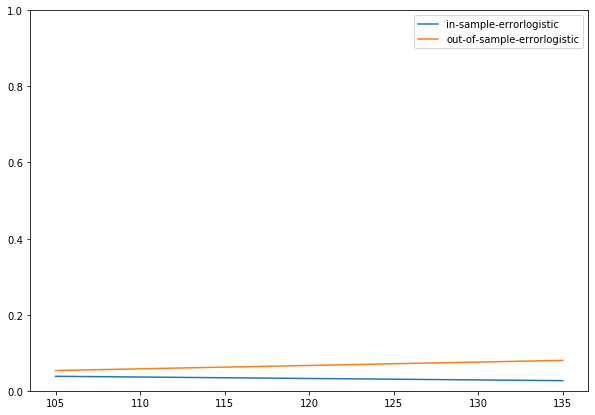

In [4]:
df = pd.read_csv('iris.csv').to_numpy()
X = df[:, :4]
Y = df[:, -1]
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
fig, ax = plt.subplots(1,1,figsize=(10,7))
plot_learning_curves(Logistic(),X,Y,ax)